In [6]:
# IMPORT DATASET
import pandas as pd
import numpy as np
df = pd.read_csv('dataset/rgs_peach_brix.csv')
# Brix data
y = df['Brix'].values
# Absorbance data
X = df.drop(['Brix'], axis=1).values
# each spectrum is taken over 600 wavelength points, from 1100 nm to 2300 nm in steps of 2 nm
wl = np.arange(1100,2300,2)

In [7]:
# MSC - MULTIPLICATIVE SCATTER CORRECTION
import matplotlib.pyplot as plt
def msc(input_data, wavelength, reference=None):
    # Mean center correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
    # Get the reference spektrum. If no given, estimate it from the mean
    if reference is None:
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference
    # Define a new array and populate it with the corrected data
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0]

    plt.figure(figsize=(12, 9))
    plt.plot(wavelength, data_msc.T)
    plt.xticks(np.arange(1100, 2300, step=100), fontsize=12, fontname="Segoe UI")
    plt.yticks(fontsize=12, fontname="Segoe UI")
    plt.title('MSC', fontweight='bold', fontsize=12, fontname="Segoe UI")
    plt.ylabel('Absorbance', fontsize=12, fontname="Segoe UI")
    plt.xlabel('Wavelength (nm)', fontsize=12, fontname="Segoe UI")
    plt.plot()

    return data_msc, ref
# https://nirpyresearch.com/two-scatter-correction-techniques-nir-spectroscopy-python/

In [8]:
# STANDARD NORMAL VARIATE
def snv(input_data, wavelength):
    # Define a new array and populate it with the corrected data
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Apply correction
        output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])

    plt.figure(figsize=(12, 9))
    plt.plot(wavelength, output_data.T)
    plt.xticks(np.arange(1100, 2300, step=100), fontsize=12, fontname="Segoe UI")
    plt.yticks(fontsize=12, fontname="Segoe UI")
    plt.title('SNV', fontweight='bold', fontsize=12, fontname="Segoe UI")
    plt.ylabel('Absorbance', fontsize=12, fontname="Segoe UI")
    plt.xlabel('Wavelength (nm)', fontsize=12, fontname="Segoe UI")
    plt.plot()
    return output_data
# https://nirpyresearch.com/two-scatter-correction-techniques-nir-spectroscopy-python/

In [9]:
# SIMPLE MOVING AVERAGE
def sma(input_data, wavelength, window_size):
    df = pd.DataFrame(input_data)
    moving_averages = df.rolling(window_size).mean()

    plt.figure(figsize=(12, 9))
    plt.plot(wavelength, moving_averages.T)
    plt.xticks(np.arange(1100, 2300, step=100), fontsize=12, fontname="Segoe UI")
    plt.yticks(fontsize=12, fontname="Segoe UI")
    plt.title('SMA', fontweight='bold', fontsize=12, fontname="Segoe UI")
    plt.ylabel('Absorbance', fontsize=12, fontname="Segoe UI")
    plt.xlabel('Wavelength (nm)', fontsize=12, fontname="Segoe UI")
    plt.plot()
    return moving_averages

In [10]:
# SAVITZKY-GOLAY SMOOTHING
from scipy.signal import savgol_filter
def SG_smoothing(input_data, wavelength, window_size, polyorder):
    SG_smoothing =savgol_filter(input_data,
                                window_length=window_size,
                                polyorder=polyorder,
                                mode="nearest")
    plt.figure(figsize=(12, 9))
    plt.plot(wavelength, SG_smoothing.T)
    plt.xticks(np.arange(1100, 2300, step=100), fontsize=12, fontname="Segoe UI")
    plt.yticks(fontsize=12, fontname="Segoe UI")
    plt.title('SG Smoothing', fontweight='bold', fontsize=12, fontname="Segoe UI")
    plt.ylabel('Absorbance', fontsize=12, fontname="Segoe UI")
    plt.xlabel('Wavelength (nm)', fontsize=12, fontname="Segoe UI")
    plt.show()
    return SG_smoothing
# https://www.datatechnotes.com/2022/05/smoothing-example-with-savitzky-golay.html

In [11]:
# SAVITZKY-GOLAY DERIVATIVE/FILTER
def SG_derivative(input_data, wavelength, window_size, polyorder, derivative):
    SG_filter = savgol_filter(input_data,
                              window_length=window_size,
                              polyorder=polyorder,
                              deriv=derivative,
                              delta=1.0,
                              axis=-1,
                              mode='interp', #'nearest'
                              cval=0.0)
    plt.figure(figsize=(12, 9))
    plt.plot(wavelength, SG_filter.T)
    plt.xticks(np.arange(1100, 2300, step=100), fontsize=12, fontname="Segoe UI")
    plt.yticks(fontsize=12, fontname="Segoe UI")
    plt.title('SG-Derivative', fontweight='bold', fontsize=12, fontname="Segoe UI")
    plt.ylabel('Absorbance', fontsize=12, fontname="Segoe UI")
    plt.xlabel('Wavelength (nm)', fontsize=12, fontname="Segoe UI")
    plt.show()
    return SG_filter
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html

In [12]:
# PARTIAL LEAST SQUARE REGRESSION
from sys import stdout
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
def optimize_pls_cv(X, y, n_comp, wavelength, plot_components=True):
    '''Run PLS including a variable number of components, up to n_component, and calculate MSE'''
    mse = []
    component = np.arange(1, n_comp)

    for i in component:
        pls = PLSRegression(n_components=i)

        # --- Cross validation
        ycv = cross_val_predict(pls, X, y, cv=10)

        mse.append(mean_squared_error(y, ycv))

        comp = 100*(i+1)/n_comp

        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")

    # Calculating and print the position of minimum in MSE
    mse_min = np.argmin(mse)
    print("Suggested number of components: ", mse_min+1)
    stdout.write("\n")

    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color='blue', mfc='blue')
            plt.plot(component[mse_min], np.array(mse)[mse_min], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components', fontsize=12, fontname='Segoe UI')
            plt.ylabel('MSE', fontsize=12, fontname='Segoe UI')
            plt.xticks(np.arange(0, 40, step=5), fontsize=12, fontname="Segoe UI")
            plt.yticks(np.arange(2.5, 5, step=0.5), fontsize=12, fontname="Segoe UI")
            plt.title('PLS')
            plt.xlim(left=-1)
            plt.show()

    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=mse_min+1)

    # Fit to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)


    plsr_coeff = np.abs(pls_opt.coef_[:,0])
    sorted_ind = np.argsort(np.abs(pls_opt.coef_[:,0]))
    Xc = X[:, sorted_ind]
    print(Xc)
    plt.plot(wavelength, plsr_coeff.T)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absolute value of PLS Coefficients')
    plt.show()

    # Cross validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=10)

    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)

    # Calculate mean squared error calibration and cross-validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)

    print('R2 calibration = %5.3f' % score_c)
    print('R2 cross-validation = %5.3f' % score_cv)
    print('MSE calibration = %5.3f' % mse_c)
    print('MSE cross-validation = %5.3f' % mse_cv)

    # Plot Regression and figures of merrit
    range_y = max(y) - min(y)
    range_x =  max(y_c) - min(y_c)

    # Fit a line to the CV vs response
    z = np.polyfit(y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9,5))
        ax.scatter(y_c, y, color='red', edgecolors='k')
        # --- Plot the best fit line
        ax.plot(np.polyval(z, y), y, color='blue', linewidth=1)
        # --- Plot the ideal 1:1 line
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV) = '+ str(score_cv), fontsize=12, fontname='Segoe UI')
        plt.xlabel('Predicted $^{\circ}$Brix', fontsize=12, fontname='Segoe UI')
        plt.ylabel('Measured $^{\circ}$Brix', fontsize=12, fontname='Segoe UI')
        plt.show()

    return n_comp

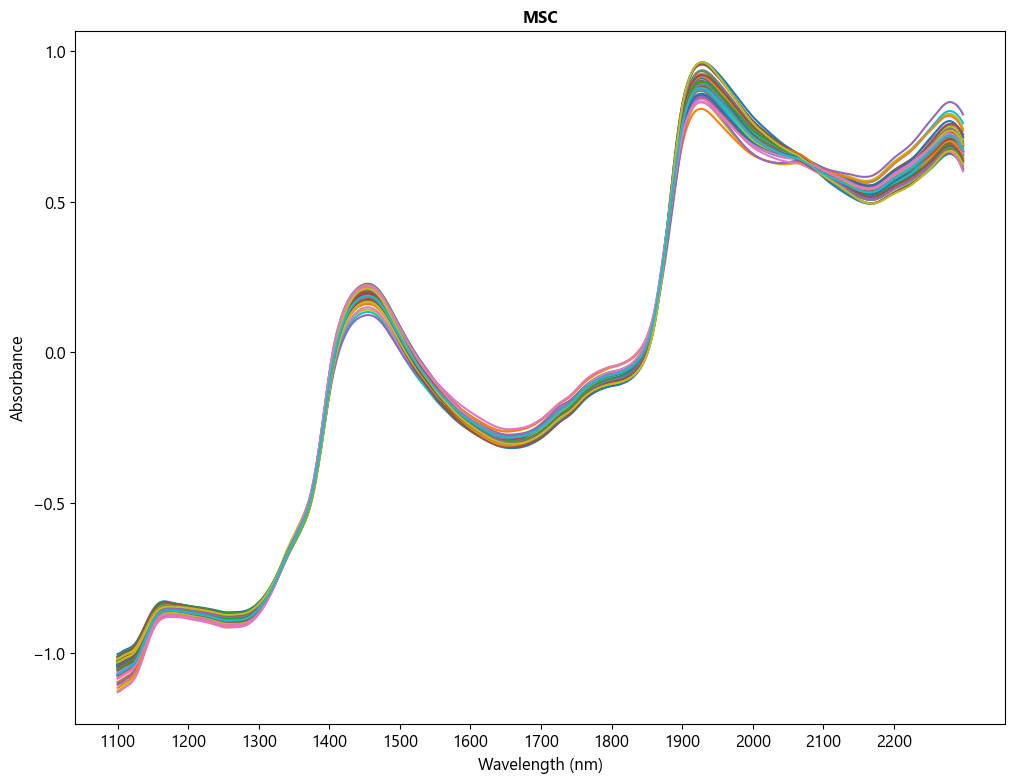

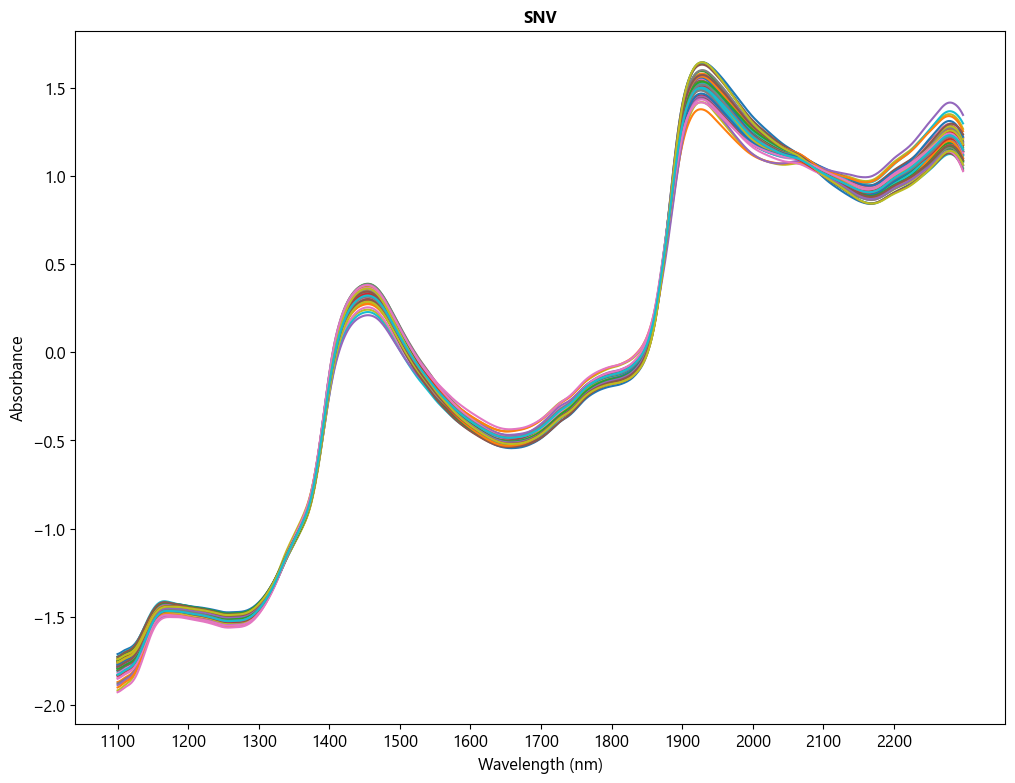

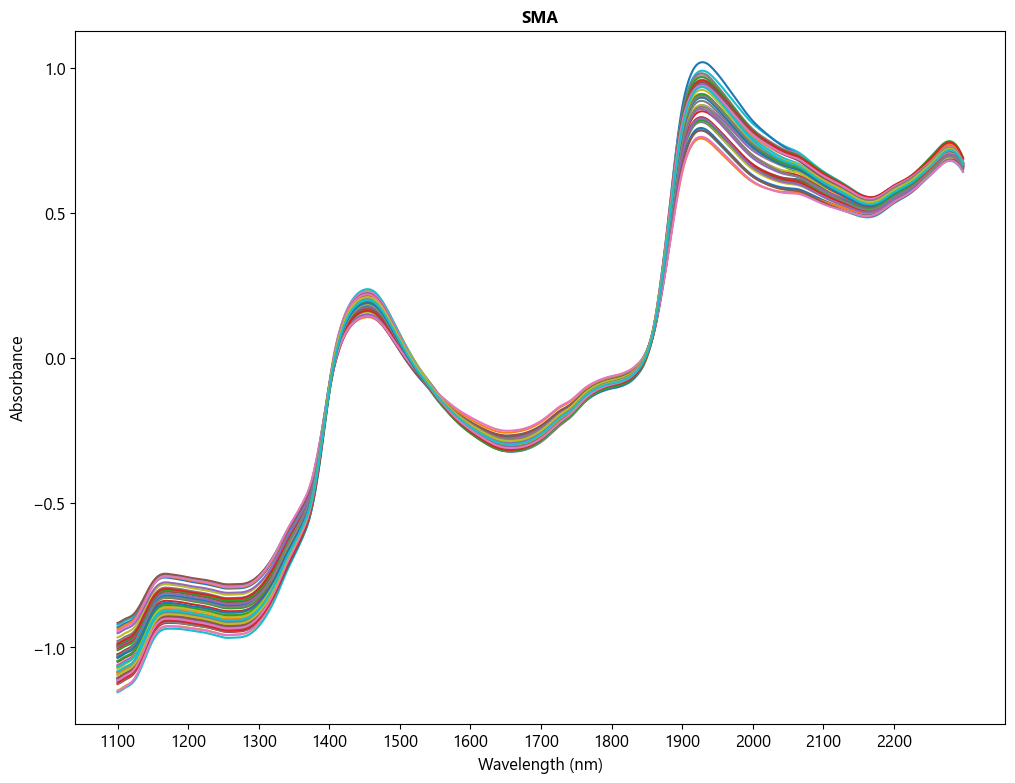

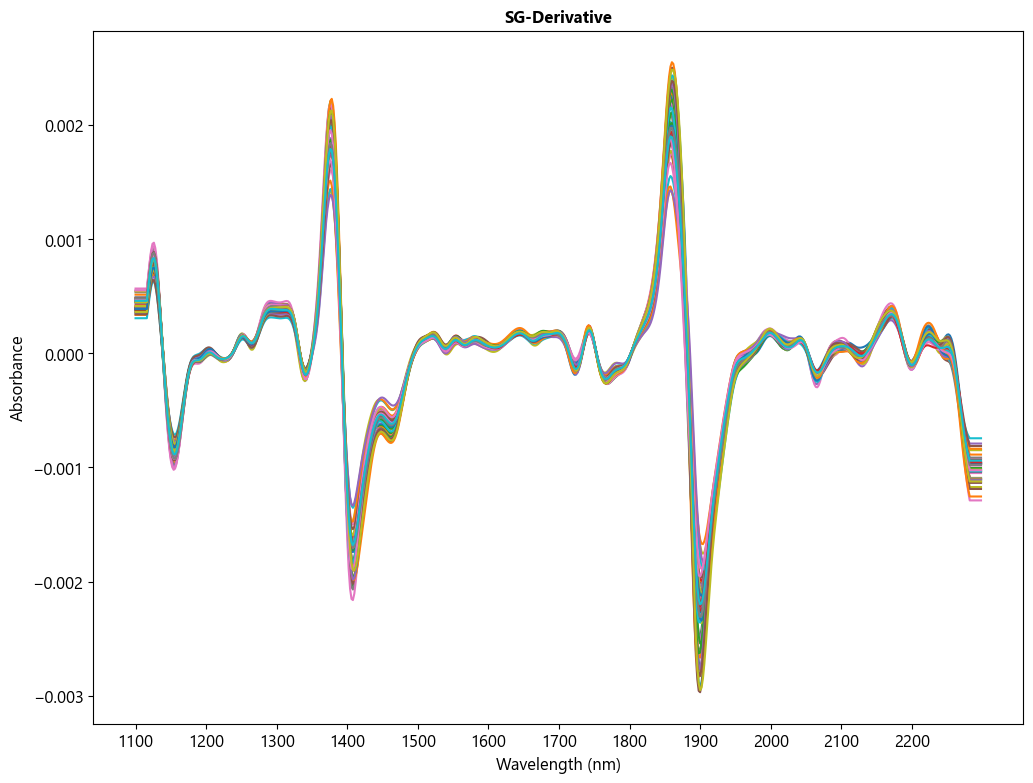

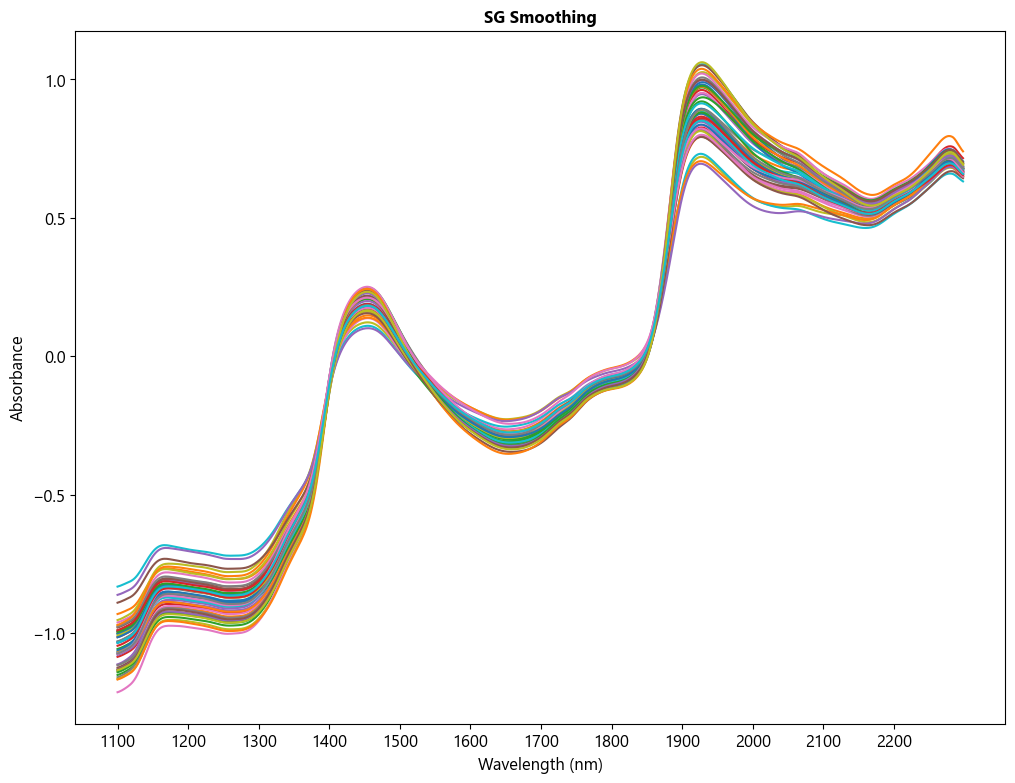

100% completed
Suggested number of components:  7



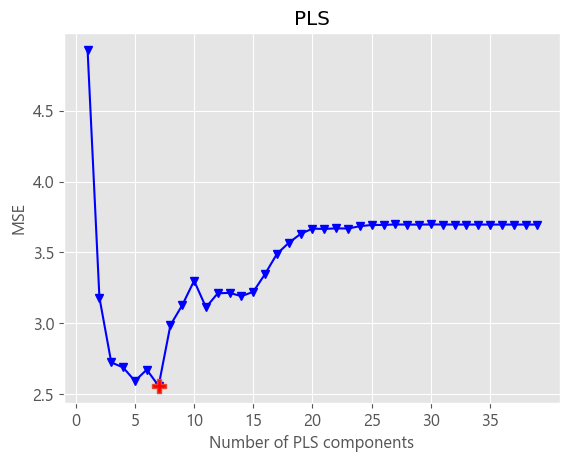

[[ 1.40627254e-03 -7.25690750e-04  1.31113713e-04 ...  1.03489841e-04
   1.11531505e-04  1.11750203e-04]
 [ 1.33316750e-03 -6.45279501e-04  3.54807634e-05 ...  1.17204337e-04
   1.19010846e-04  1.15065915e-04]
 [ 1.47355059e-03 -7.15342376e-04  8.23091878e-05 ...  1.14845181e-04
   1.23374353e-04  1.23627819e-04]
 ...
 [ 1.23695383e-03 -6.17239965e-04  8.77626656e-05 ...  1.18868039e-04
   1.24627391e-04  1.23712797e-04]
 [ 1.47357345e-03 -7.46637888e-04  1.13090833e-04 ...  1.30385438e-04
   1.34330156e-04  1.32312971e-04]
 [ 1.19789559e-03 -5.97826302e-04  5.14010591e-05 ...  1.14397877e-04
   1.16958351e-04  1.12841469e-04]]


C:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


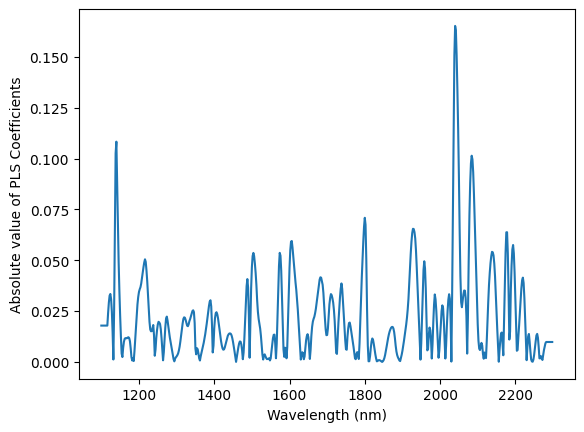

R2 calibration = 0.859
R2 cross-validation = 0.451
MSE calibration = 0.657
MSE cross-validation = 2.558


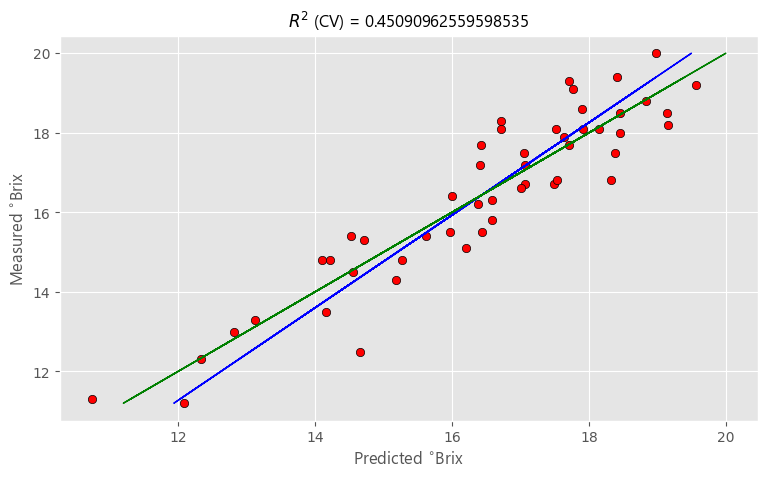

In [13]:
# RUN PROGRAM
if __name__ == '__main__':
    Xmsc = msc(X, wl)[0]
    Xsnv = snv(X, wl)
    Xsma = sma(X, wl, 3)
    Xsgf = SG_derivative(X, wl, 17, 2, 2)
    Xsgs = SG_smoothing(X, wl, 15, 3)
    optimize_pls_cv(Xsgf, y, 40, wl, plot_components=True)